In [91]:
import track
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
proj = track.Project("./remote_logs/logs", None)  # None = remote url
vanilla_ids = proj.ids[proj.ids['lr_dropout_rate'] == 1.0]['trial_id']
lrd_ids = proj.ids[proj.ids['lr_dropout_rate'] == 0.5]['trial_id']

vanilla = proj.results(vanilla_ids)
lrd = proj.results(lrd_ids)

In [93]:
### Average accuracy over all seeds
def seed_avg(df, col, ids):
    #return df[df['trial_id'].isin(ids)].groupby(['trial_id'])[col].mean()
    return df.groupby(['iteration']).mean()[col]

vanilla_test_accs = seed_avg(vanilla, 'test_acc', vanilla_ids)
vanilla_train_accs = seed_avg(vanilla, 'train_acc', vanilla_ids)
lrd_test_accs = seed_avg(lrd, 'test_acc', lrd_ids)
lrd_train_accs = seed_avg(lrd, 'train_acc', lrd_ids)

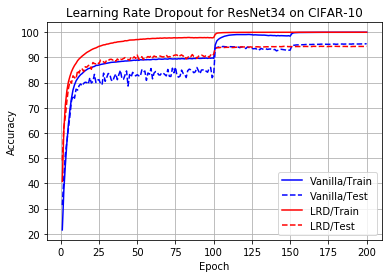

In [94]:
### Plotting
x = list(range(1, 201))

markersize = 12

## vanilla
plt.plot(x, vanilla_train_accs, label='Vanilla/Train', color='b', markersize=markersize)
plt.plot(x, vanilla_test_accs, label='Vanilla/Test', color='b', linestyle='dashed', markersize=markersize)
## learning rate dropout
plt.plot(x, lrd_train_accs, label='LRD/Train', color='r', markersize=markersize)
plt.plot(x, lrd_test_accs, label='LRD/Test', color='r', linestyle='dashed', markersize=markersize)

# plt
plt.title('Learning Rate Dropout for ResNet34 on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [95]:
print("Vanilla test max acc: %.4f" % vanilla_test_accs.max())
print("LRD test max acc: %.4f" % lrd_test_accs.max())

Vanilla test max acc: 95.4500
LRD test max acc: 94.4250
